In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '15'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
data_dir = Path("train")

images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split("_")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16
img_width = 256
img_height = 65
downsample_factor = 4

max_length = max([len(label) for label in labels])

Number of images found:  3000
Number of labels found:  3000
Number of unique characters:  26
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'H', 'J', 'K', 'L', 'M', 'N', 'S', 'T', 'V', 'X', 'Y', 'Z']


In [4]:
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}


In [5]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

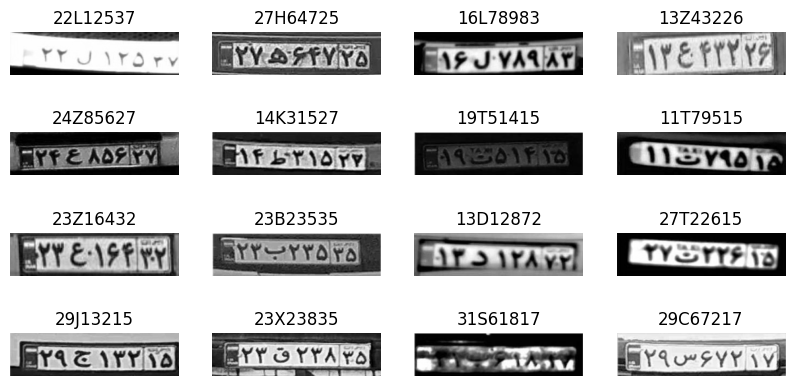

In [6]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [7]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred



def build_model():
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1", )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2", )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)


    x = layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv3", )(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)

    x = layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv4", )(x)
    x = layers.MaxPooling2D((2, 2), name="pool4")(x)
    
    new_shape = ((img_width // 16), (img_height // 16) * 256)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 256, 65, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 256, 65, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 128, 32, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 128, 32, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [8]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=0.001)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100


I0000 00:00:1719948326.682369   12979 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


169/169 [==============================] - 17s 40ms/step - loss: 21.3709 - val_loss: 19.4924 - lr: 0.0010
Epoch 2/100
169/169 [==============================] - 3s 21ms/step - loss: 18.9734 - val_loss: 18.1135 - lr: 0.0010
Epoch 3/100
169/169 [==============================] - 3s 21ms/step - loss: 17.7559 - val_loss: 17.2144 - lr: 0.0010
Epoch 4/100
169/169 [==============================] - 3s 21ms/step - loss: 16.7202 - val_loss: 15.6161 - lr: 0.0010
Epoch 5/100
169/169 [==============================] - 3s 21ms/step - loss: 14.8449 - val_loss: 13.5028 - lr: 0.0010
Epoch 6/100
169/169 [==============================] - 3s 21ms/step - loss: 11.3934 - val_loss: 7.8060 - lr: 0.0010
Epoch 7/100
169/169 [==============================] - 3s 21ms/step - loss: 7.1323 - val_loss: 5.0441 - lr: 0.0010
Epoch 8/100
169/169 [==============================] - 3s 21ms/step - loss: 5.0471 - val_loss: 3.7072 - lr: 0.0010
Epoch 9/100
169/169 [==============================] - 3s 21ms/step - loss: 3.79

In [9]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 65, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 256, 65, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 128, 32, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 64, 16, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 64, 16, 128)       73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 32, 8, 128)        0     

In [10]:
model.evaluate(validation_dataset)

19/19 [==============================] - 0s 9ms/step - loss: 0.7719


0.7719342112541199

In [11]:
import cv2
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def prediction_image_with_path(image_path):
    img_height, img_width = 65, 256
    test_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plate = test_img.astype(np.float32) / 255.0
    plate = cv2.resize(plate, dsize=(256, 65))
    plate = np.transpose(plate, (1, 0))
    plate = np.expand_dims(plate, axis=-1)

    if plate.shape != (256, 65, 1):
        raise ValueError("Input image must have shape (256, 65, 1)")
    plate = np.expand_dims(plate, axis=0)
    plate = plate.astype('float32')
    preds = prediction_model.predict(plate)
    pred_texts = decode_batch_predictions(preds)
    return test_img, pred_texts

1/1 [==============================] - 0s 16ms/step


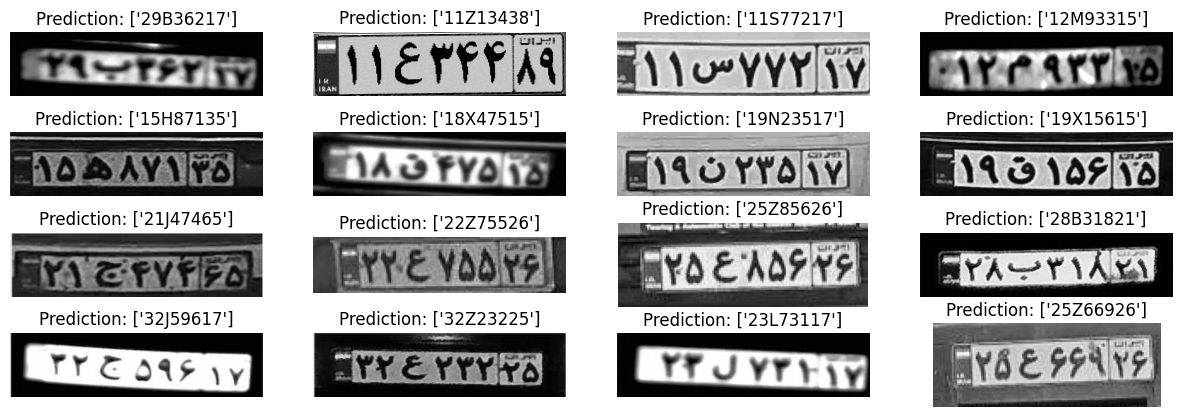

In [12]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(0, 16):
    img , lbl = prediction_image_with_path('test/' + str(i) + '.jpg')
    title = f"Prediction: {lbl}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()

In [13]:
model.save('CTCModel.tf')

INFO:tensorflow:Assets written to: CTCModel.tf/assets


INFO:tensorflow:Assets written to: CTCModel.tf/assets


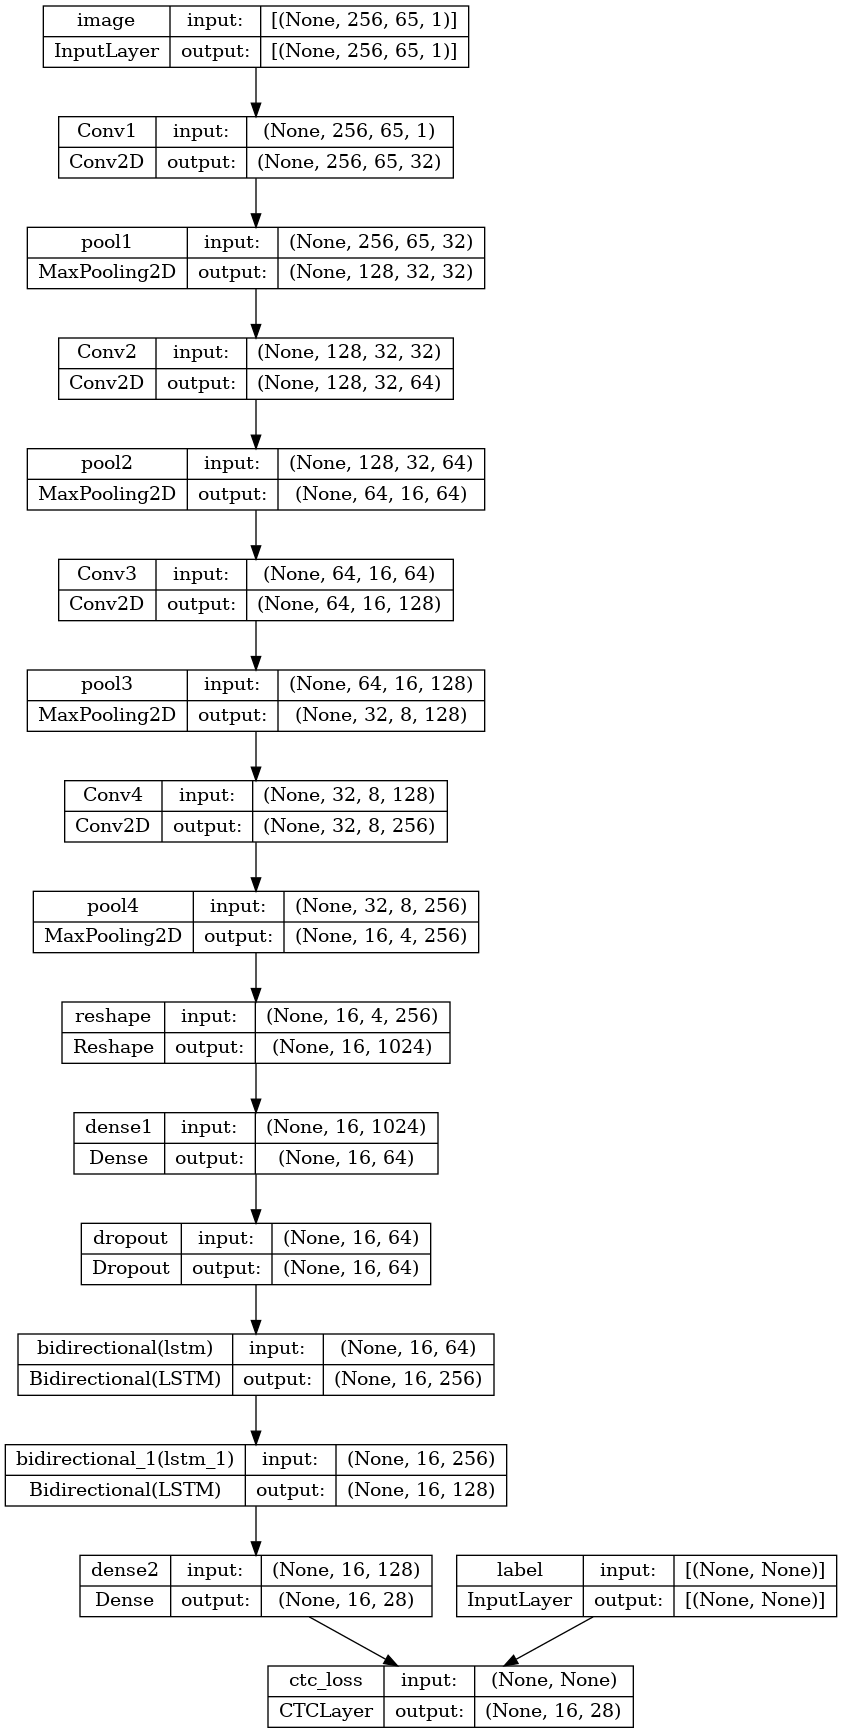

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)